**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

Целевой признак: факт ухода клиента

<h1>План<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-и-подготовка-данных" data-toc-modified-id="Анализ-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ и подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li>

## Анализ и подготовка данных

In [ ]:
!pip install phik
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    accuracy_score
)

In [ ]:
import phik
from phik import resources, report

In [ ]:
pip install pandas-profiling

     |████████████████████████████████| 324 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 352 kB 25.8 MB/s eta 0:00:01
     |████████████████████████████████| 460 kB 69.9 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 79.3 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 57.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 77.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 63.7 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=51bc74a11aa753ef8baa0ac6dea311c68245efe3dd12c56c85130daa3ca9531a
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# константа
RANDOM_STATE = 30723
# количество фолдов для кросс-валидации
CV = 6

In [ ]:
person = pd.read_csv('/datasets/personal_new.csv')
contract = pd.read_csv('/datasets/contract_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Анализ исходных данных

In [ ]:
# функция для обзора данных
def intro (df):
    df.info()
    display(df.shape)
    display(df.head())
    print('Явных дубликатов:', df.duplicated().sum())
    display(df.describe(include='all'))
    print('Пропуски:'+'\n', df.isna().sum())

In [ ]:
# обзор датасета с данными о клиентах
intro(person)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


(7043, 5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Явных дубликатов: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,8118-LSUEL,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Пропуски:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [ ]:
# проверка на неявные дубликаты по полю customerID без учета регистра
person['customerID'].str.lower().duplicated().sum()

0

В датасете `person` 7043 записи. Пропущенных значений нет. Дубликатов по номеру клиента (`customerID`) без учета регистра нет. Признаки `Dependents`, `Partner`, `gender` - бинарные. Признак `SeniorCitizen`, судя по смыслу признака и диапазону принимаемых значений (от 0 до 1), тоже бинарный.

In [ ]:
# обзор датасета с данными о договорах
intro(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


(7043, 8)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Явных дубликатов: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,8118-LSUEL,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Пропуски:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [ ]:
# проверка на неявные дубликаты по полю customerID без учета регистра
contract['customerID'].str.lower().duplicated().sum()

0

In [ ]:
# проверка на адекватность данных в столбце `BeginDate`, где дата не может быть позднее даты выгрузки датасета (1 фев 2020)
contract.BeginDate.max()

'2020-02-01'

В столбце `TotalCharges` имеется пустое значение. К тому же оно является самым часто встречающимся из всех уникальных значений этого столбца. Проверим это значение.

In [ ]:
contract['TotalCharges'].value_counts().to_frame().head(3)

,TotalCharges
,11
20.45,6
101.0,5


Строк, которые имеют пустое значение в столбце `TotalCharges`, 11. Выведем эти строки.

In [ ]:
contract.query('TotalCharges ==  " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Заметим, что это строки о клиентах, которые заключили договор 1 фев 2020 - дата выгрузки датасета.\
Проверим, все ли клиенты, заключившие договор 1 фев 2020, имеют пустое значение в столбце `TotalCharges`.

In [ ]:
contract.query('BeginDate ==  "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [ ]:
len(contract.query('BeginDate ==  "2020-02-01"'))

11

Можно сделать вывод, что все клиенты, заключившие договор 1 фев 2020, имеют пустое значение в столбце `TotalCharges`. Для обучения модели эти данные неинформативны, поскольку не дают вклад в понимание о лояльности клиента. Их удалим после объединения этого датасета с данными из других датасетов.

В датасете `contract` 7043 записи. Явных дубликатов, пропусков нет. Тип данных "строковый", кроме столбца `MonthlyCharges`, где данные вещественного типа. Дубликатов по номеру клиента (`customerID`) без учета регистра нет. Признак `PaperlessBilling` - бинарный. Признак `Type` имеет 3 категории, `PaymentMethod` - 4.

In [ ]:
# обзор датасета с данными о подключенных интернет-услугах
intro(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


(5517, 8)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Явных дубликатов: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0824-VWDPO,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Пропуски:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [ ]:
internet['customerID'].str.lower().duplicated().sum()

0

В датасете `internet` 5517 записей, что меньше, чем в предыдущих датасетах. Явных дубликатов, пропусков нет. Тип данных "строковый" Дубликатов по номеру клиента (customerID) без учета регистра нет. Признаки бинарные.

In [ ]:
# обзор датасета с данными о подключенных услугах телефонии
intro(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


(6361, 2)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Явных дубликатов: 0


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8118-LSUEL,No
freq,1,3390


Пропуски:
 customerID       0
MultipleLines    0
dtype: int64


In [ ]:
phone['customerID'].str.lower().duplicated().sum()

0

В датасете `phone` 6361 запись, что меньше, чем в двух первых датасетах. Явных дубликатов, пропусков нет. Тип данных "строковый". Дубликатов по номеру клиента (customerID) без учета регистра нет. Признак бинарный.

### Предобработка данных

In [ ]:
df = contract.copy()

In [ ]:
# объединение всех четырех таблиц в одну
df = contract.merge(person, on='customerID', how='left')

In [ ]:
df = df.merge(phone, on='customerID', how='left')

In [ ]:
df = df.merge(internet, on='customerID', how='left')

In [ ]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [ ]:
# удаление клиентов, которые заключили договор в дату выгрузки датасетов
df = df.query('BeginDate != "2020-02-01"')

In [ ]:
len(df)

7032

11 клиентов удалено. Проверка на  адекватность значения в поле `EndDate`- неадекватной будет дата расторжения договора в дату выгрузки датасета или более позднюю дату.

In [ ]:
df['EndDate'].value_counts().to_frame().head(3)

,EndDate
No,5931
2020-01-01,39
2019-12-01,38


Создаем столбец с целевым признаком - `Target`

In [ ]:
df['Target'] = (df['EndDate'] != 'No').astype(int)

In [ ]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,NaN,DSL,Yes,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,No,DSL,Yes,Yes,No,No,No,No,1


Создание нового признака - Продолжительность использования клиентом услуг `Duration`. Продолжительность посчитаем, вычислив длительность действия договора (в днях). Для клиентов, активных на момент выгрузки данных, отсчет произведем от даты выгрузки (1 фев 2020)

In [ ]:
df.EndDate = df.EndDate.replace(to_replace='No', value='2020-02-01')

In [ ]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,NaN,DSL,Yes,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,No,DSL,Yes,Yes,No,No,No,No,1


In [ ]:
df['Duration'] = (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days

In [ ]:
# проверка правильности заполнения столбца `Duration`
df[['BeginDate', 'EndDate','Duration', 'Target']].head(10)

,BeginDate,EndDate,Duration,Target
0,2020-01-01,2020-02-01,31,0
1,2017-04-01,2020-02-01,1036,0
2,2019-10-01,2020-02-01,123,0
3,2016-05-01,2020-02-01,1371,0
4,2019-09-01,2020-02-01,153,0
5,2019-03-01,2020-02-01,337,0
6,2018-04-01,2020-02-01,671,0
7,2019-04-01,2020-02-01,306,0
8,2017-07-01,2020-02-01,945,0
9,2014-12-01,2017-05-01,882,1


Исследование баланса классов целевого признака

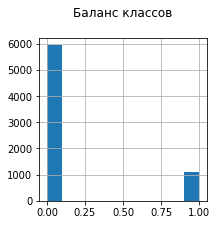

In [ ]:
df['Target'].hist(figsize=(3,3))
plt.title('Баланс классов'+'\n');

Клиентов, ушедших от провайдера, значительно меньше, чем активных клиентов.

Для обучения модели номер клиента, дата заключения договора и дата его расторжения не несут смысловую нагрузку. Их удаляем

In [ ]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [ ]:
# приведение названия столбцов к единообразию, а именно `gender` -> `Gender`
df.rename({'gender': 'Gender'}, axis=1, inplace=True)

In [ ]:
df.head(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Target,Duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036


In [ ]:
# проверка на дубликаты после удаления столбцов
df.duplicated().sum()

4

In [ ]:
# удаление дубликатов, т к для обучения модели дубликаты не нужны
df = df.drop_duplicates()

Преобразование типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7028 non-null   object 
 1   PaperlessBilling  7028 non-null   object 
 2   PaymentMethod     7028 non-null   object 
 3   MonthlyCharges    7028 non-null   float64
 4   TotalCharges      7028 non-null   object 
 5   Gender            7028 non-null   object 
 6   SeniorCitizen     7028 non-null   int64  
 7   Partner           7028 non-null   object 
 8   Dependents        7028 non-null   object 
 9   MultipleLines     6348 non-null   object 
 10  InternetService   5511 non-null   object 
 11  OnlineSecurity    5511 non-null   object 
 12  OnlineBackup      5511 non-null   object 
 13  DeviceProtection  5511 non-null   object 
 14  TechSupport       5511 non-null   object 
 15  StreamingTV       5511 non-null   object 
 16  StreamingMovies   5511 non-null   object 


In [ ]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
df.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Target,Duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,0,123


In [ ]:
# проверка на пропущенные значения, которые возникли в таблице после объединения с другими таблицами
df.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        680
InternetService     1517
OnlineSecurity      1517
OnlineBackup        1517
DeviceProtection    1517
TechSupport         1517
StreamingTV         1517
StreamingMovies     1517
Target                 0
Duration               0
dtype: int64

Поскольку пропуски в итоговой таблице возникли из-за того, что некоторые клиенты не пользовались теми или иними сервисами, то заполним пропуски значением `not_used`

In [ ]:
df = df.fillna('not_used')

In [ ]:
df.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Target              0
Duration            0
dtype: int64

In [ ]:
# матрица корреляций признаков
df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Target', 'Duration']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Target,Duration
Type,1.000000,0.106366,0.277502,0.388376,0.470329,0.000000,0.085796,0.179004,0.146014,0.243524,0.504357,0.636343,0.581064,0.631110,0.671229,0.548948,0.554000,0.094682,0.635284
PaperlessBilling,0.106366,1.000000,0.368131,0.466780,0.201493,0.000000,0.241546,0.011368,0.171560,0.099971,0.230780,0.207730,0.194642,0.194982,0.199977,0.204202,0.201586,0.082553,0.017525
PaymentMethod,0.277502,0.368131,1.000000,0.398216,0.334297,0.000000,0.291709,0.244388,0.222988,0.174918,0.322618,0.314331,0.292066,0.296610,0.316252,0.283356,0.284296,0.214091,0.348179
MonthlyCharges,0.388376,0.466780,0.398216,1.000000,0.710646,0.008612,0.304421,0.204186,0.183070,0.710264,0.918983,0.812470,0.818794,0.827299,0.816562,0.864779,0.863502,0.225856,0.386947
TotalCharges,0.470329,0.201493,0.334297,0.710646,1.000000,0.000000,0.136769,0.382620,0.085094,0.467587,0.489051,0.516210,0.550354,0.558507,0.527680,0.555432,0.553845,0.303621,0.847539
Gender,0.000000,0.000000,0.000000,0.008612,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009241,0.000000
SeniorCitizen,0.085796,0.241546,0.291709,0.304421,0.136769,0.000000,1.000000,0.018102,0.323766,0.088024,0.160425,0.126990,0.109750,0.109922,0.134957,0.111518,0.113525,0.085543,0.064985
Partner,0.179004,0.011368,0.244388,0.204186,0.382620,0.000000,0.018102,1.000000,0.651560,0.086182,0.000000,0.091047,0.091913,0.099610,0.076145,0.081778,0.077636,0.227686,0.449500
Dependents,0.146014,0.171560,0.222988,0.183070,0.085094,0.000000,0.323766,0.651560,1.000000,0.011405,0.107805,0.116462,0.097119,0.093960,0.109004,0.087645,0.084348,0.048682,0.196873
MultipleLines,0.243524,0.099971,0.174918,0.710264,0.467587,0.000000,0.088024,0.086182,0.011405,1.000000,0.739773,0.539944,0.562693,0.564510,0.540659,0.586168,0.586821,0.105223,0.346591


Говоря о целевом признаке можно заметить, что имеется средней выраженности положительная корреляция между ним и `TotalCharges`, а также между ним и длительностью действия договора на оказание услуг `Duration`.

## Обучение моделей

In [ ]:
# выделение исследуемых и целевого признака, разбиение на тернировочную и тестовою в соотношении 3:1
features = df.drop('Target', axis=1)
target = df['Target']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE, stratify=target)

#проверка размерности тренировочной и тестовой
display(X_train.shape, X_train.shape, y_test.shape, y_test.shape)

(5271, 18)

(5271, 18)

(1757,)

(1757,)

Выделение численных и категориальных признаков.\
Из анализа данных, проведенного в первой части проекта, можно заметить, что в основном признаки датасета - категориальные. Численными являются признаки об оплате, а также созданный новый признак `Duration` (продолжительность действия договора)

In [ ]:
num_features = ['MonthlyCharges', 'TotalCharges', 'Duration']
ohe_features = X_train.columns.to_list()
for feature in num_features:
    ohe_features.remove(feature)
ohe_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [ ]:
# проверка общего количества признаков после их разделения на численные и категориальные
display(len(num_features) + len(ohe_features))
len(X_train.columns.to_list())

18

18

### Ridge

In [ ]:
# кодирование и масштабирование признаков с помощью make_column_transformer:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [ ]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [ ]:
# подбор гиперпараметров с помощью GridSearchCV, который имеет встроенную кросс-валидацию для модели Ridge
model_ridge = Ridge(random_state=RANDOM_STATE)

pipeline_ridge = make_pipeline(col_transformer, model_ridge)

param_grid_ridge = {
    'ridge__alpha': np.arange (0, 0.21, 0.01),
}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge,
    param_grid=param_grid_ridge,
    scoring='roc_auc',
    n_jobs=-1,
    cv=CV
)

gs_ridge_pl.fit(X_train_ridge, y_train)

gs_ridge_best_score = gs_ridge_pl.best_score_
gs_ridge_best_params = gs_ridge_pl.best_params_

# лучшее значение метрики на кросс-валидации
print(f'Ridge best_score: %s' % round((gs_ridge_best_score),2))

# лучшие гиперпараметры
print(f'Ridge best_params: {gs_ridge_best_params}')

Ridge best_score: 0.77
Ridge best_params: {'ridge__alpha': 0.2}


###  RandomForestClassifier

In [ ]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [ ]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': np.arange (100, 251, 50),
    'randomforestclassifier__max_depth': np.arange (4, 11),
    'randomforestclassifier__min_samples_split': np.arange (2, 5),
    'randomforestclassifier__min_samples_leaf': np.arange (1, 4)
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает намного быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    cv=CV
)

In [ ]:
%%time
gs_rf.fit(X_train_rf, y_train)

CPU times: user 36.8 s, sys: 0 ns, total: 36.8 s
Wall time: 37.1 s


RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'Gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBacku...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=30723))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'randomforestclassifier__min_samples_leaf': array([1, 2, 3]),
                                        'randomforestclassifier__min_samples_split': array([2, 3, 4]),
                                        'randomforestclassifier__n_estimators': array([100, 150, 200, 250])},
                   scoring='roc_auc')

In [ ]:
print(f'Random Forest best_score: %s' % round((gs_rf.best_score_),2))
print(f'Random Forest best_params: {gs_rf.best_params_}')

Random Forest best_score: 0.83
Random Forest best_params: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 9}


### CatBoost

In [ ]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [ ]:
cb_model = CatBoostClassifier(
    eval_metric='AUC',
    random_state=RANDOM_STATE,
    loss_function= 'Logloss',
)

# зададим параметры
params = {'depth' : range(5, 8),
            'learning_rate' : [0.1],
            'iterations' : range(200, 301, 50),
}

search_cat = GridSearchCV(cb_model, params, scoring='roc_auc', cv=CV, n_jobs=-1, verbose=100)

In [ ]:
%%time
model_cat = search_cat.fit(X_train_cb, y_train, cat_features=ohe_features, verbose=200)

Fitting 6 folds for each of 9 candidates, totalling 54 fits
[CV 1/6; 1/9] START depth=5, iterations=200, learning_rate=0.1..................
0:	total: 59.2ms	remaining: 11.8s
199:	total: 1.9s	remaining: 0us
[CV 1/6; 1/9] END depth=5, iterations=200, learning_rate=0.1;, score=0.859 total time=   2.8s
[CV 2/6; 1/9] START depth=5, iterations=200, learning_rate=0.1..................
0:	total: 11ms	remaining: 2.18s
199:	total: 1.8s	remaining: 0us
[CV 2/6; 1/9] END depth=5, iterations=200, learning_rate=0.1;, score=0.842 total time=   2.6s
[CV 3/6; 1/9] START depth=5, iterations=200, learning_rate=0.1..................
0:	total: 13ms	remaining: 2.58s
199:	total: 1.89s	remaining: 0us
[CV 3/6; 1/9] END depth=5, iterations=200, learning_rate=0.1;, score=0.839 total time=   2.6s
[CV 4/6; 1/9] START depth=5, iterations=200, learning_rate=0.1..................
0:	total: 16.3ms	remaining: 3.23s
199:	total: 1.81s	remaining: 0us
[CV 4/6; 1/9] END depth=5, iterations=200, learning_rate=0.1;, score=0.8

In [ ]:
print('Best score CatBoost при кросс-валидации: %s' % round((model_cat.best_score_),2))
print('Best CatBoost Model Hyperparameters: %s' % model_cat.best_params_)

Best score CatBoost при кросс-валидации: 0.89
Best CatBoost Model Hyperparameters: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}


### LightGBM

In [ ]:
X_train_lg = X_train.copy()
X_test_lg = X_test.copy()

In [ ]:
model_lgb = lgb.LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)

# укажем для модели категориальные данные
for c in ohe_features:
    X_train_lg[c] = X_train_lg[c].astype('category')

# проверка типов данных
X_train_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271 entries, 5897 to 2511
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              5271 non-null   category
 1   PaperlessBilling  5271 non-null   category
 2   PaymentMethod     5271 non-null   category
 3   MonthlyCharges    5271 non-null   float64 
 4   TotalCharges      5271 non-null   float64 
 5   Gender            5271 non-null   category
 6   SeniorCitizen     5271 non-null   category
 7   Partner           5271 non-null   category
 8   Dependents        5271 non-null   category
 9   MultipleLines     5271 non-null   category
 10  InternetService   5271 non-null   category
 11  OnlineSecurity    5271 non-null   category
 12  OnlineBackup      5271 non-null   category
 13  DeviceProtection  5271 non-null   category
 14  TechSupport       5271 non-null   category
 15  StreamingTV       5271 non-null   category
 16  StreamingMovies   527

In [ ]:
param_grid_lgb = {
    'n_estimators': range (200, 251, 50),
    'max_depth': range (4, 6)
}

gs_lgb = RandomizedSearchCV(
    model_lgb,
    param_distributions=param_grid_lgb,
    scoring='roc_auc',
    n_jobs=-1,
    cv=CV,
    verbose=100
)

In [ ]:
%%time
gs_lgb = gs_lgb.fit(X_train_lg, y_train)

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[CV 1/6; 1/4] START max_depth=4, n_estimators=200...............................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/6; 1/4] END max_depth=4, n_estimators=200;, score=0.866 total time=  25.0s
[CV 2/6; 1/4] START max_depth=4, n_estimators=200...............................
[CV 2/6; 1/4] END max_depth=4, n_estimators=200;, score=0.855 total time=  25.7s
[CV 3/6; 1/4] START max_depth=4, n_estimators=200...............................
[CV 3/6; 1/4] END max_depth=4, n_estimators=200;, score=0.859 total time=  19.5s
[CV 4/6; 1/4] START max_depth=4, n_estimators=200...............................
[CV 4/6; 1/4] END max_depth=4, n_estimators=200;, score=0.893 total time=  31.7s
[CV 5/6; 1/4] START max_depth=4, n_estimators=200...............................
[CV 5/6; 1/4] END max_depth=4, n_estimators=200;, score=0.885 total time=  28.9s
[CV 6/6; 1/4] START max_depth=4, n_estimators=200...............................
[CV 6/6; 1/4] END max_depth=4, n_estimators=200;, score=0.904 total time=  19.1s
[CV 1/6; 2/4] START max_depth=4, n_estimators=250...............................
[CV 1/6; 2/4] END max_depth=

In [ ]:
print(f'LightGBM best_score: %s' % round((gs_lgb.best_score_),2))
print(f'LightGBM best_params: {gs_lgb.best_params_}')

LightGBM best_score: 0.89
LightGBM best_params: {'n_estimators': 250, 'max_depth': 5}


In [ ]:
# значение метрики ROC-AUC по всем моделям
result = pd.DataFrame(
    [gs_ridge_best_score, gs_rf.best_score_, model_cat.best_score_, gs_lgb.best_score_],
    index=['Ridge', 'RandomForestClassifier', 'CatBoost', 'LGBM'],
    columns=['roc_auc']
)
result

,roc_auc
Ridge,0.765166
RandomForestClassifier,0.829925
CatBoost,0.886454
LGBM,0.885986


Лучший результат метрики ROC-AUC дала модель CatBoost c подобранными гиперпараметрами:

In [ ]:
model_cat.best_params_

{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}

## Тестирование модели

Модель, показавшe. лучший результат на кросс-валидации (CatBoost), тестируем на тестовой выборке (с уже подобранными лучшими гиперпараметрами `best_estimator_`).

In [ ]:
pred_proba = model_cat.best_estimator_.predict_proba(X_test_cb)[:, 1]
print('ROC-AUC: ',roc_auc_score(y_test, pred_proba))

ROC-AUC:  0.8953870690712796


Значение метрики ROC-AUC на тестовой выборке равно 0,895, что удовлетворяет условиям поставленной задачи (данная метрика должна быть не менее 0,85)

In [ ]:
round(accuracy_score(y_test, model_cat.best_estimator_.predict(X_test_cb)),2)

0.9

Метрика accuracy у лучшей модели 0,9

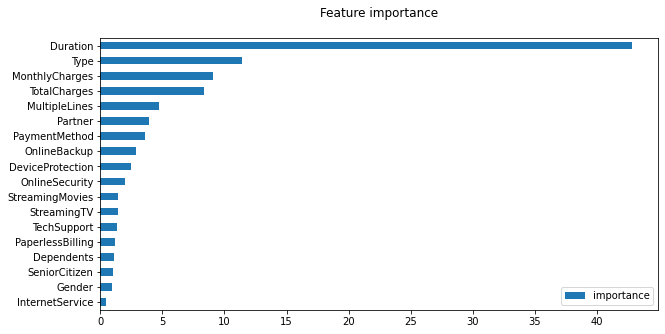

In [ ]:
# визуализация важности признаков
importances_df = pd.DataFrame(model_cat.best_estimator_.feature_importances_, index = X_test_cb.columns, columns=['importance'])
importances_df = importances_df.sort_values(by='importance', ascending=True)
importances_df.plot(kind='barh', figsize=(10, 5), title='Feature importance'+'\n')
plt.show()

Наиболее важными в построенной модели являются признаки: продолжительность действия договора, тип договора, размер ежемесячного платежа.

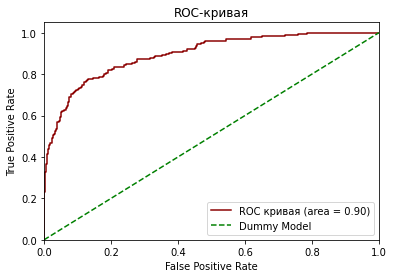

ROC_AUC:  0.8953870690712796


In [ ]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)
# строим график ROC-AUC
plt.plot(fpr, tpr, color='darkred',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='green', linestyle='--', label='Dummy Model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
print('ROC_AUC: ',roc_auc_score(y_test, pred_proba))

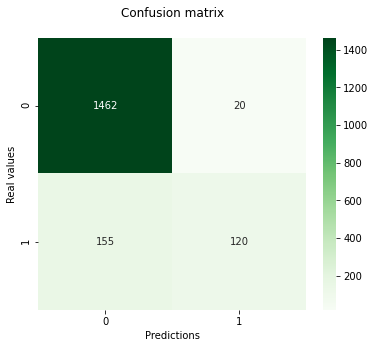

In [ ]:
# матрица ошибок
cmatrix = confusion_matrix(y_test, model_cat.best_estimator_.predict(X_test_cb))
plt.figure(figsize=(6, 5))
sns.heatmap(cmatrix,
                annot=True,
                cmap='Greens',
                fmt='d').set(title='Confusion matrix'+'\n', xlabel='Predictions', ylabel='Real values')
plt.show();

## Вывод

Были построены и обучены с помощью кросс-валидации и подбором гиперпараметров следующие модели: Ridge, RandomForestClassifier, CatBoostClassifier, LightGBMClassifier. Датасет был разделен на тренировочную и тестовую в соотношении 3:1. Ввиду дисбаланса классов разделение произведено со стратификацией по целевому признаку.\
Лучший результат показала модель CatBoostClassifier с метрикой ROC-AUC = 0.886 при кросс-валидации. Значение метрики удовлетворяет условию поставленной задачи (ROC-AUC не меньше 0,85). Для лучшей модели на тестовой выборке метрика accuracy равна 0,9, метрика ROC-AUC равна 0,895.\
Наиболее важными в выбранной модели являются признаки: продолжительность действия договора, тип договора, размер ежемесячного платежа. Заметим, что при анализе данных самая высокая положительная корреляция (методом phik) целевого признака была замечена именно со сроком действия договора.\
Модель хорошо предсказывает клиентов, которые не собираются уходить от провайдера. Однако, не очень хорошо предсказывает клиентов, которые собираются уходить от провайдера. В этом можно наметить направление деятельности для дальнейшего улучшения модели.